# Cross-validation of models for Stoeckius et al.

In [1]:
# Import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import importlib

import bottleneck_networks_tf2

import time
import pickle
import warnings

dtype = tf.float32

def sns_styleset():
    sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})

# Loading data

In [2]:
stoeckius = pickle.load(open('data/stoeckius_2017/stoeckius_2017.pickle', 'rb'))
genes=stoeckius['X']
adt=stoeckius['Y']
gene_names=stoeckius['gene_names']
adt_names=stoeckius['adt_features']
cell_types=stoeckius['celltypes']

Let us find K-mean clusters to perform pre-training. One could also pre-train on celltype classification. This has actually improved performance even more but could be argued to be biasing the results too much. K-means allows for an unsupervised more general setting.

In [ ]:
# You can cluster according to amounts of classes or amounts of celltypes. Change the argument of n_clusters accordingly.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=17, n_init=1000).fit(adt)

In [ ]:
clusters = kmeans.labels_

In [ ]:
amount_of_cells_in_clusters = {cluster_id: sum(clusters==cluster_id) for cluster_id in np.unique(clusters)}
for_every_cell_number_of_cells_of_their_cluster = np.array([amount_of_cells_in_clusters[cell] for cell in clusters])
ind_pre_training_clusters = for_every_cell_number_of_cells_of_their_cluster >= 10

In [ ]:
c_n=[]
for i in np.unique(clusters):
    print('cluster ', i, 'represented by', sum(clusters==i), ' cells.')
    c_n.append(sum(clusters==i))
print('average # of cells per cluster: ', np.mean(np.array(c_n)))
print('std of # of cells per cluster: ', np.std(np.array(c_n)))

# Keras initialisations

In [ ]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
# You should assume you get two TensorFlow variables as input
y_actual = tf.compat.v1.placeholder(dtype = tf.float32)
y_predicted = tf.compat.v1.placeholder(dtype = tf.float32)
def r2_score(y_truth, y_pred):
    residual = tf.add(y_truth, -y_pred, name='residual')
    return 1-tf.reduce_sum(input_tensor=tf.square(residual)) / tf.reduce_sum(input_tensor=tf.square(y_truth))
r2_score_result = r2_score(y_actual, y_predicted)

In [ ]:
class ElasticNet(tf.keras.regularizers.Regularizer): 
    def __init__(self, l1=1e-8, l2=1.0): 
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x): 
        return self.l2*tf.math.reduce_sum(input_tensor=tf.math.square(x)) + \
                             self.l1*tf.reduce_sum(input_tensor=tf.norm(tensor=x, ord = 2, axis = 1))

    def get_config(self): 
        return {'l1': float(self.l1), 'l2': float(self.l2)}

# Group lasso sBNNs vs sRRR

Group lasso + ridge penalty straight regression (no pre-training) model.

In [ ]:
from bottleneck_networks_tf2 import StraightRegression

In [ ]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-2])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
prune=True
patience=epochs

r2_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = adt[ind,:]

nodes_list=[512,128,64,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            BN_StraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                                       input_dim=input_dim, output_dim=output_dim, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_ap_train, r2_ap_test, \
                train_hist, test_hist = BN_StraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=gene_names, \
                                                                                   verbose=0)
            r2_straight_regr[cvfold, j, i] = r2_test
            r2_straight_regr_tr[cvfold, j, i] = r2_train
            r2_straight_regr_ap[cvfold, j, i] = r2_ap_test
            r2_straight_regr_ap_tr[cvfold, j, i] = r2_ap_train
            r2_straight_regr_hist[cvfold, j, i] = test_hist
            r2_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (straight regression, no pre-tr): ', r2_straight_regr[cvfold, j, i])
            #print('Test R^2 score after pruning (straight regression, no pre-tr): ', r2_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

In [ ]:
with open('KerasSavedModels/stoeckius_2017_tf2/Bottleneck_r2_straight_regr_lasso_no_bottleneck.pickle', 'wb') as f:
    pickle.dump([r2_straight_regr, r2_straight_regr_tr, \
                 r2_straight_regr_ap, r2_straight_regr_ap_tr, \
                 r2_straight_regr_hist, r2_straight_regr_hist_tr], f)

Group lasso + ridge penalty classification pre-training model.

In [ ]:
from bottleneck_networks_tf2 import ClassificationPreTrain

In [ ]:
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = adt[ind,:]
clusters_ = clusters[ind]
ind_pre_train = ind_pre_training_clusters[ind]

CE_loss = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))

nodes_list=[512,128,64,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    clusters_train = np.copy(clusters_[indtrain])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    clusters_test = np.copy(clusters_[indtest])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean

    # In our training set we now look for a 'pretraining' training and test data set that we can use
    # for pretraing a classification network, i.e. picking the best model will be dones with a seperate val set in our
    # training set for regression.

    x_train_pre_tr = x_train[ind_pre_train[indtrain], :]
    clusters_train_pre_tr = clusters_train[ind_pre_train[indtrain]]
    
    pre_train_size = 0.6
    train_cnt = round(x_train_pre_tr.shape[0]*pre_train_size)
    x_train_pre_tr_ = x_train_pre_tr[:train_cnt, :]
    x_test_pre_tr_ = x_train_pre_tr[train_cnt:, :]
    clusters_train_pre_tr_ = clusters_train_pre_tr[:train_cnt]
    clusters_test_pre_tr_ = clusters_train_pre_tr[train_cnt:]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)


            input_dim = x_train.shape[1]
            output_dim = to_categorical(clusters_train_pre_tr).shape[1]
            BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                       output_dim=output_dim, nodes_list=nodes_list)
            CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                               cluster_train=clusters_train_pre_tr_, \
                                                                               x_test=x_test_pre_tr_, \
                                                                               cluster_test=clusters_test_pre_tr_, \
                                                                               epochs=epochs, bs=bs, patience=patience, \
                                                                               cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                               verbose=0)
            CE_loss[cvfold, j, i] = CE_test
            CE_loss_tr[cvfold, j, i] = CE_train
            pre_tr_hist[cvfold, j, i] = test_hist
            pre_tr_hist_tr[cvfold, j, i] = train_hist
            #print('Test CE loss (pre-trainin): ', CE_loss[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

In [ ]:
with open('KerasSavedModels/stoeckius_2017_tf2/Bottleneck_pre_tr_lasso_no_bottleneck.pickle', 'wb') as f:
    pickle.dump([CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr], f)

Group lasso + ridge penalty pre-train and regression model.

In [ ]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-2])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
prune=True

r2_pretr_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_pretr_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = adt[ind,:]

nodes_list=[512,128,64,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, 1, i)
            
            BN_PreTrStraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                            input_dim=input_dim, output_dim=output_dim, \
                                            pre_trained_weights=pre_trained_weights, \
                                            pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_train_ap, r2_test_ap, \
                train_hist, test_hist = BN_PreTrStraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=gene_names, \
                                                                                   verbose=0)
            r2_pretr_straight_regr[cvfold, j, i] = r2_test
            r2_pretr_straight_regr_tr[cvfold, j, i] = r2_train
            r2_pretr_straight_regr_ap[cvfold, j, i] = r2_test_ap
            r2_pretr_straight_regr_ap_tr[cvfold, j, i] = r2_train_ap            
            r2_pretr_straight_regr_hist[cvfold, j, i] = test_hist
            r2_pretr_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (regression, after pre-tr): ', r2_pretr_straight_regr[cvfold, j, i])
            #print('Test R^2 score (regression, after pre-tr), after pruning: ', r2_pretr_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

In [ ]:
with open('KerasSavedModels/stoeckius_2017_tf2/Bottleneck_r2_pre_tr_and_straight_regr_lasso_no_bottleneck.pickle', 'wb') as f:
    pickle.dump([r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
                 r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
                 r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr], f)

Group lasso + ridge penalty pre-train + freeze the first 2 layers + unfreeze model.

In [ ]:
from bottleneck_networks_tf2 import FreezeUnfreeze

In [ ]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True

r2_before_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = adt[ind,:]

nodes_list=[512,128,64,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, j, i)
            input_dim = x_train.shape[1]
            output_dim = y_train.shape[1]
            BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_before_unfreezing_train, r2_before_unfreezing_test, \
                r2_after_unfreezing_train, r2_after_unfreezing_test, \
                r2_after_unfreezing_train_ap, r2_after_unfreezing_test_ap, \
                train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                    x_test=x_test, y_test=y_test, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                    prune=prune, geneNames=gene_names, \
                                                                    verbose=0, citeseq=True,
                                                                    report_individual_ephys_feature_test_R2=True)
            r2_before_unfreezing[cvfold, j, i] = r2_before_unfreezing_test
            r2_before_unfreezing_tr[cvfold, j, i] = r2_before_unfreezing_train
            r2_after_unfreezing[cvfold, j, i] = r2_after_unfreezing_test
            r2_after_unfreezing_tr[cvfold, j, i] = r2_after_unfreezing_train
            r2_after_unfreezing_ap[cvfold, j, i] = r2_after_unfreezing_test_ap
            r2_after_unfreezing_ap_tr[cvfold, j, i] = r2_after_unfreezing_train_ap
            r2_freeze_unfreeze_hist[cvfold, j, i] = test_hist
            r2_freeze_unfreeze_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing and after pruning): ', r2_after_unfreezing_ap[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

In [23]:
np.load('KerasSavedModels/individual_ephys_feature_test_R2_{}_2_0_citeseq_nb.npz'\
                                                             .format(0))['R2']

array([0.68037912, 0.72811532, 0.5689221 , 0.58264244, 0.40663415,
       0.57080832, 0.10615176, 0.58327883, 0.40241086, 0.72818899,
       0.31799388, 0.25014192, 0.15662211])

In [24]:
individual_ephys_test_R2_scores=np.zeros((folds,Y.shape[1]))
for i in range(folds):
    individual_ephys_test_R2_scores[i,:]=np.load('KerasSavedModels/individual_ephys_feature_test_R2_{}_2_0_citeseq_nb.npz'\
                                                             .format(i))['R2']
individual_R2_scores={}
individual_R2_scores_std={}
for i in range(Y.shape[1]):
    individual_R2_scores.update(
        {adt_names[i]:np.mean(individual_ephys_test_R2_scores, axis=0)[i]}
                               )
    individual_R2_scores_std.update(
        {adt_names[i]:np.std(individual_ephys_test_R2_scores, axis=0)[i]}
                               )
R2_full=np.mean(r2_freeze_unfreeze_hist[:,2,0,-1],axis=0)
print('R^2 score on all: ', R2_full)
print('\nindividual contributions: ')
individual_R2_scores

R^2 score on all:  0.4101868808269501

individual contributions: 


{'CD3': 0.6719305217266083,
 'CD4': 0.7318877637386322,
 'CD8': 0.5610631734132767,
 'CD45RA': 0.6014104723930359,
 'CD56': 0.4462966352701187,
 'CD16': 0.5101750075817109,
 'CD10': 0.07867608070373536,
 'CD11c': 0.5371045142412185,
 'CD14': 0.4096261978149414,
 'CD19': 0.6845614194869996,
 'CD34': 0.23508129119873047,
 'CCR5': 0.18599206805229188,
 'CCR7': 0.10646897554397583}

In [25]:
with open('KerasSavedModels/stoeckius_2017/ind_feature_scores_nb.pickle', 'wb') as f:
    pickle.dump([individual_R2_scores, individual_R2_scores_std], f)

In [26]:
# For the revision, before, without ion channel genes:
print("individual contributions \w their std's")
individual_R2_scores_std

individual contributions \w their std's


{'CD3': 0.015124150873722951,
 'CD4': 0.0229780523929734,
 'CD8': 0.08102109375560686,
 'CD45RA': 0.05390684422475656,
 'CD56': 0.09449168084214607,
 'CD16': 0.06340568141055705,
 'CD10': 0.04559344733933164,
 'CD11c': 0.07144945987702112,
 'CD14': 0.05422050641862873,
 'CD19': 0.08164135630590177,
 'CD34': 0.08112934770481357,
 'CCR5': 0.08804431868219756,
 'CCR7': 0.04246898384850332}

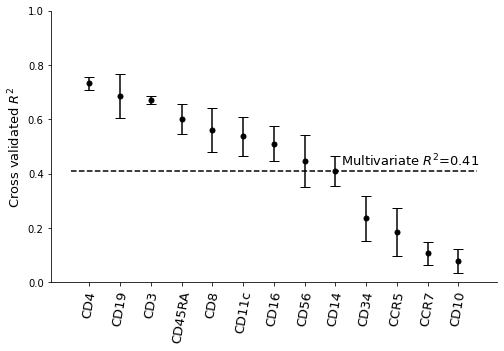

In [27]:
# For the revision, before, without ion channel genes:
order=np.argsort(np.array([individual_R2_scores[key] for key in individual_R2_scores]))[::-1]
fig, ax = plt.subplots(1,1,figsize=(8,5))
# ax.scatter(
#            np.array([key for key in individual_R2_scores])[order],
#            np.array([individual_R2_scores[key] for key in individual_R2_scores])[order],
#            color='k'
#           )
ax.errorbar(np.array([key for key in individual_R2_scores])[order],
            np.array([individual_R2_scores[key] for key in individual_R2_scores])[order],
            np.array([individual_R2_scores_std[key] for key in individual_R2_scores_std])[order],
            marker='.', color='k', markersize=10, capsize=5, linestyle='none')
ax.hlines(R2_full,
          xmin=ax.get_xlim()[0],
          xmax=ax.get_xlim()[1],
          linestyle='dashed')
ax.set_ylim(ymin=0,ymax=1)
ax.annotate(r'Multivariate $R^2$={0:.2f}'.format(R2_full),
           (ax.get_xlim()[0]+1.3*(ax.get_xlim()[1]-ax.get_xlim()[0])/2, R2_full+0.02),
            fontsize=13)
plt.xticks(rotation='80', fontsize=13)
ax.set_ylabel(r'Cross validated $R^2$', fontsize=13)
sns.despine()
# plt.savefig('./figures/preliminary/individual_ephys_prediction_scores_cite_seq.png',
#             bbox_inches = 'tight',
#             pad_inches = 0)
# plt.savefig('./figures/preliminary/individual_ephys_prediction_scores_cite_seq.pdf',
#             bbox_inches = 'tight',
#             pad_inches = 0)

In [ ]:
with open('KerasSavedModels/stoeckius_2017_tf2/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso_no_bottleneck.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

Let us now analyse and visualise the differences.

In [28]:
lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

In [29]:
with open('KerasSavedModels/stoeckius_2017_tf2/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [30]:
with open('KerasSavedModels/stoeckius_2017_tf2/sRRR_vs_Bottleneck_rank13_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank13, r2_sRRR_relaxed_rank13, r2_sRRR_rank13_tr, r2_sRRR_relaxed_rank13_tr, \
                nonzero_rank13, corrs_rank13, corrs_relaxed_rank13 = pickle.load(f)

In [31]:
with open('KerasSavedModels/stoeckius_2017_tf2/Bottleneck_pre_tr_lasso.pickle', 'rb') as f:
    CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr = pickle.load(f)

In [32]:
with open('KerasSavedModels/stoeckius_2017_tf2/Bottleneck_pre_tr_lasso_no_bottleneck.pickle', 'rb') as f:
    CE_loss_nb, CE_loss_tr_nb, pre_tr_hist_nb, pre_tr_hist_tr_nb = pickle.load(f)

In [33]:
with open('KerasSavedModels/stoeckius_2017_tf2/Bottleneck_r2_straight_regr_lasso.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
    r2_straight_regr_ap, r2_straight_regr_ap_tr, \
    r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

In [34]:
with open('KerasSavedModels/stoeckius_2017_tf2/Bottleneck_r2_straight_regr_lasso_no_bottleneck.pickle', 'rb') as f:
    r2_straight_regr_nb, r2_straight_regr_tr_nb, \
    r2_straight_regr_ap_nb, r2_straight_regr_ap_tr_nb, \
    r2_straight_regr_hist_nb, r2_straight_regr_hist_tr_nb = pickle.load(f)

In [35]:
with open('KerasSavedModels/stoeckius_2017_tf2/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
    r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
    r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

In [36]:
with open('KerasSavedModels/stoeckius_2017_tf2/Bottleneck_r2_pre_tr_and_straight_regr_lasso_no_bottleneck.pickle', 'rb') as f:
    r2_pretr_straight_regr_nb, r2_pretr_straight_regr_tr_nb, \
    r2_pretr_straight_regr_ap_nb, r2_pretr_straight_regr_ap_tr_nb, \
    r2_pretr_straight_regr_hist_nb, r2_pretr_straight_regr_hist_tr_nb = pickle.load(f)

In [37]:
with open('KerasSavedModels/stoeckius_2017_tf2/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [38]:
with open('KerasSavedModels/stoeckius_2017_tf2/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso_no_bottleneck.pickle', 'rb') as f:
    r2_before_unfreezing_nb, r2_before_unfreezing_tr_nb, \
    r2_after_unfreezing_nb, r2_after_unfreezing_tr_nb, \
    r2_after_unfreezing_ap_nb, r2_after_unfreezing_ap_tr_nb, \
    r2_freeze_unfreeze_hist_nb, r2_freeze_unfreeze_hist_tr_nb = pickle.load(f)

In [39]:
# Select closest to 25 genes value
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank13 = np.nanmean(nonzero_rank13, axis=0)[0, :]
    r_rank13_r = np.nanmean(r2_sRRR_relaxed_rank13, axis=0)[0, :]

In [40]:
print(r_rank13_r[np.isclose(n_rank13, 25, atol=3)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank13, axis=0)[0, :][np.isclose(n_rank13, 25, atol=3)][0])

0.35180883035772514 +/- 0.05748617418606928


In [41]:
print(r_rank2_r[np.isclose(n_rank2, 25, atol=3)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank2, axis=0)[0, :][np.isclose(n_rank2, 25, atol=3)][0])

0.23040445534801773 +/- 0.03808543922420419


In [42]:
print(np.mean(r2_freeze_unfreeze_hist,axis=0)[2,0,-1], '+/-', np.std(r2_freeze_unfreeze_hist,axis=0)[2,0,-1])

0.37927199676632883 +/- 0.10156890367252856


In [43]:
print(np.mean(r2_freeze_unfreeze_hist_nb,axis=0)[2,0,-1], '+/-', np.std(r2_freeze_unfreeze_hist_nb,axis=0)[2,0,-1])

0.4101868808269501 +/- 0.13671620335855833


In [44]:
print(np.mean(r2_straight_regr_hist,axis=0)[0,0,-1], '+/-', np.std(r2_straight_regr_hist,axis=0)[0,0,-1])

0.37438757717609406 +/- 0.048559528654080183


In [45]:
print(np.mean(r2_straight_regr_hist_nb,axis=0)[0,0,-1], '+/-', np.std(r2_straight_regr_hist_nb,axis=0)[0,0,-1])

0.36065409407019616 +/- 0.12723368034785434


In [24]:
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank13 = np.nanmean(nonzero_rank13, axis=0)[0, :]
    r_rank13_r = np.nanmean(r2_sRRR_relaxed_rank13, axis=0)[0, :]

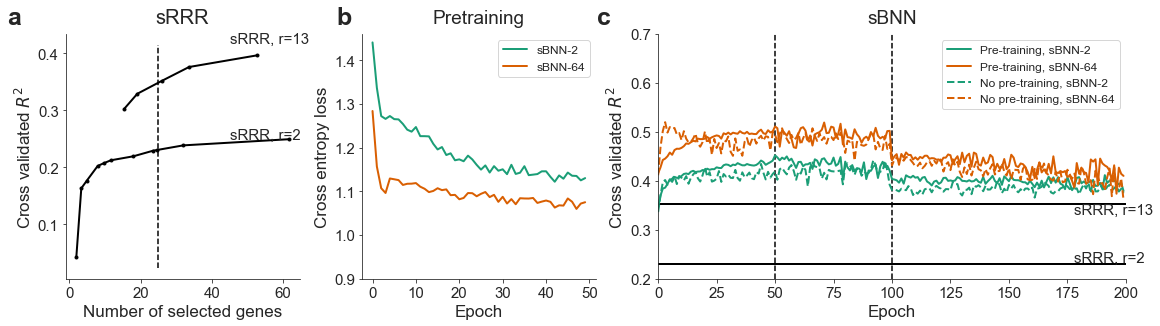

In [47]:
# All together in one plot
linewidth = 2
sns_styleset()

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank13 = np.nanmean(nonzero_rank13, axis=0)[0, :]
    r_rank13_r = np.nanmean(r2_sRRR_relaxed_rank13, axis=0)[0, :]

# All together in one plot for the paper
fig = plt.figure(figsize=(19, 4.5))
widths = [1, 1, 2]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                          height_ratios=heights)
ax1 = fig.add_subplot(spec[0, 0])
ax1.plot(n_rank2, r_rank2_r, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
ax1.plot(n_rank13[1:], r_rank13_r[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
#ax1.set_ylim([0.1,0.45])
ax1.set_xlabel('Number of selected genes', fontsize = 17)
ax1.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax1.set_title('sRRR', fontsize = 20, y=1.02)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.vlines(x=25, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.annotate('sRRR, r=13', (45, np.max(r_rank13_r)+0.0003), fontsize=15)
ax1.annotate('sRRR, r=2', (45, np.max(r_rank2_r)+0.0003), fontsize=15)


ax2 = fig.add_subplot(spec[0, 1])
ax2.plot(range(50), np.mean(pre_tr_hist, axis=(0, 2))[2, :], \
         c = '#1b9e77', linewidth=linewidth, label='sBNN-2')
ax2.plot(range(50), np.mean(pre_tr_hist_nb, axis=(0, 2))[2, :], \
         c = '#d95f02', linewidth=linewidth, label='sBNN-64')
ax2.set_title('Pretraining', fontsize = 19, y=1.02)
ax2.set_xlabel('Epoch', fontsize = 17)
ax2.set_ylabel('Cross entropy loss', fontsize = 17)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_ylim([0.9, ax2.get_ylim()[1]])
ax2.set_xticks(np.arange(0, 60, 10))
ax2.legend(loc='best', fontsize=12)

epochs_used=200
ax3 = fig.add_subplot(spec[0, 2])
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis=(0))[2,0,:], \
        c='#1b9e77', linewidth=linewidth, label='Pre-training, sBNN-2')
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_nb, axis=(0))[2,0,:], \
        c='#d95f02', linewidth=linewidth, label='Pre-training, sBNN-64')
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist, axis=(0))[0,0,:], \
        '--', c='#1b9e77', linewidth=linewidth, label='No pre-training, sBNN-2')
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist_nb, axis=(0))[0,0,:], \
        '--', c='#d95f02', linewidth=linewidth, label='No pre-training, sBNN-64')
ax3.hlines(r_rank13_r[np.isclose(n_rank13, 25, atol=5)][0], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=5)][0], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.set_ylim([0.2,0.7])
ax3.set_xlim([0,200])
ax3.set_xticks(np.arange(0, 225, 25))
ax3.annotate('sRRR, r=13', (178, r_rank13_r[np.isclose(n_rank13, 25, atol=5)][0]-0.02), fontsize=15)
ax3.annotate('sRRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=5)][0]+0.003), fontsize=15)
ax3.set_title('sBNN', fontsize = 19, y=1.02)
ax3.set_xlabel('Epoch', fontsize = 17)
ax3.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.legend(loc='upper right', fontsize=12)
ax3.vlines(x=50, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')
ax3.vlines(x=100, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')

plt.text(-0.25, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.11, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.13, 1.04, 'c', transform = ax3.transAxes, fontsize=25, fontweight='bold')
sns.despine()

plt.savefig('figures/Lasso_training_curves_stoeckius.pdf', bbox_inches='tight',
    pad_inches=0)
plt.savefig('figures/Lasso_training_curves_stoeckius.png', bbox_inches='tight',
    pad_inches=0)